Read the data and import necessary libraries.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
import math
import numpy as np

df=pd.read_excel("Cell_Azimuth.xlsx") #read file which contains Cell , Location and Actual Cell Azimuth information
df.head()

,Cell,longitude_event,latitude_event,longitude_site,latitude_site,azimuth
0,A,28.98503,41.01652,28.984139,41.016611,330
1,A,28.98594,41.01627,28.984139,41.016611,330
2,A,28.98445,41.01642,28.984139,41.016611,330
3,A,28.98540,41.01588,28.984139,41.016611,330
4,A,28.98070,41.00252,28.984139,41.016611,330


Define functions that ; find azimuth between site location and event locations 
                        find distance between site location and event locations 

In [2]:
def azimuth(q1,q2,h1,h2): # find azimuth between 2 points
    #inputs are latitude1,latitude2,longitude1,longitude2
    return math.degrees(math.atan2(math.cos(math.radians(q2)) * math.sin(math.radians(h2-h1))  , (math.cos(math.radians(q1)) * math.sin(math.radians(q2)) - math.sin(math.radians(q1))*math.cos(math.radians(q2))*math.cos(math.radians(h2-h1))) ))
def distance(q1,q2,h1,h2):# find distance between 2 points
    #inputs are latitude1,latitude2,longitude1,longitude2
    a = math.sin(math.radians(q2-q1)/2)* math.sin(math.radians(q2-q1)/2) + math.cos(math.radians(q1))*math.cos(math.radians(q2))*math.sin(math.radians(h2-h1)/2)*math.sin(math.radians(h2-h1)/2)
    c = 2* math.atan2(math.sqrt(a),math.sqrt(1-a))
    R=6371
    distance =  R*c
    return distance


Find our predicted Azimuth value of each cell in Dataframe with median of event azimuths

In [3]:
#Group dataframe by Cell and find the median of the event points    
median_df = df.groupby(["Cell" ,"longitude_site","latitude_site" ,"azimuth"]).agg({'longitude_event':'median','latitude_event':'median'})
median_df = median_df.reset_index()
# apply azimuth function to our median Dataframe
median_df['azimuth_predicted'] = median_df.apply(lambda x: azimuth(x['latitude_site'], x['latitude_event'],x["longitude_site"], x["longitude_event"]), axis=1)
#Replace negative azimuth values to positive by adding 360 degree
median_df.loc[(median_df.azimuth_predicted < 0), 'azimuth_predicted']  = median_df.azimuth_predicted + 360
#Round azimuth_predicted value for easy to show
median_df.azimuth_predicted = round(median_df.azimuth_predicted,1)
median_df.head()

,Cell,longitude_site,latitude_site,azimuth,longitude_event,latitude_event,azimuth_predicted
0,A,28.984139,41.016611,330,28.98524,41.01628,111.7
1,B,28.984139,41.016611,120,28.98218,41.02001,336.5


Define a function that finds if that 2 cells serves each other's areas (CROSS)

In [4]:
def is_serve_each_others_area(beamwidth=40):#find if cells serves each others area
    #input is beamwidth of the antenna
    Cells = list(median_df.Cell.unique())
    azimuth1 = median_df[median_df.Cell ==Cells[0]].azimuth.values[0]
    azimuth2 = median_df[median_df.Cell ==Cells[1]].azimuth.values[0]
    azimuth_predicted1 = median_df[median_df.Cell ==Cells[0]].azimuth_predicted.values[0]
    azimuth_predicted2 = median_df[median_df.Cell ==Cells[1]].azimuth_predicted.values[0]
    if abs((azimuth1-azimuth_predicted2)<beamwidth or abs(azimuth1-azimuth_predicted2)>360-beamwidth) and abs((azimuth2-azimuth_predicted1)<beamwidth or abs(azimuth2-azimuth_predicted1)>360-beamwidth):
    
        return "yes"
    else:
        return "no"
is_serve_each_others_area()

'yes'

'yes' means there can be cross between these cells.

If the output is yes ;
we can create a DataFrame that contains azimuth values on column headers, and distance values at columns.

In [14]:
if is_serve_each_others_area()== "yes":
    # apply azimuth function to our Dataframe
    df['events_azimuth'] = df.apply(lambda x: azimuth(x['latitude_site'], x['latitude_event'],x["longitude_site"], x["longitude_event"]), axis=1)
    # apply distance function to our Dataframe
    df['distance'] = df.apply(lambda x: distance(x['latitude_site'], x['latitude_event'],x["longitude_site"], x["longitude_event"]), axis=1)
    #Replace negative azimuth values to positive by adding 360 degree
    df.loc[(df.events_azimuth < 0), 'events_azimuth']  = df.events_azimuth + 360
    #Round azimuth values
    df.events_azimuth = round(df.events_azimuth,2)
    
    #Pivot our Dataframe to create radar chart
    azimuth_table = pd.pivot_table(df, values='distance', index=["Cell"],
                        columns=['events_azimuth'], aggfunc=np.average).fillna(0).reset_index()
    #Merge our Dataframe to Median Dataframe
    azimuth_table = azimuth_table.merge(median_df[["Cell","azimuth","azimuth_predicted"]],on="Cell")
azimuth_table.head()

,Cell,1.49,2.25,2.32,3.05,4.33,7.05,8.72,10.76,11.29,...,348.44,349.38,352.46,352.53,354.25,354.42,354.53,355.72,azimuth,azimuth_predicted
0,A,0.000000,0.000000,0.000000,0.000000,0.0679,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,330,111.7
1,B,0.390304,0.173475,0.333736,0.222583,0.0000,0.411068,0.044875,0.243221,7.457653,...,0.384634,0.058704,1.450174,0.089595,1.339836,1.301469,1.309055,0.290908,120,336.5


So lets create a function that visualize these informations with 2 radar graphs together

In [15]:
def radar_graph(Cell,sayac,gdf=df,table=azimuth_table):#create dynamic radar graphs
    ax = plt.subplot(1,2,sayac, polar=True)
    #in default polar plot values increasing counterclockwise, we need to set point of top to "N" and reverse increasing direction
    ax.set_theta_zero_location("N")# change theta location, cos 
    ax.set_theta_direction(-1)# reverse direction to see correct azimuth values
    ax.set_rlabel_position(0)
    categories = list(table)[1:-2]# discard non azimuth values in Dataframe
    angles= [n / float(360) * 2 * pi for n in categories] # find angles
    angles += angles[:1] # add angles first value for create a close loop
    thetas = table.loc[table.Cell == Cell].values.tolist()[0][1:-2] + [0] # locate this Cell values
    non_thetas=[]
    for i in sorted(thetas):
        if i !=0.00:
            non_thetas.append(i)
    pop_count = len(non_thetas)/10          #discard outliers for plotting
    if int(pop_count) !=0:
        for i in non_thetas[-int(pop_count):]:
            angles.pop(thetas.index(i))
            thetas.pop(thetas.index(i)) 
    max_thetas = max(thetas) #find max thetas
    values_az = gdf.loc[gdf.Cell  == Cell].azimuth.mean() # Find mean azimuth for labelling at chart
    azimuth_predicted = table.loc[table.Cell  == Cell].azimuth_predicted.mean()
    BW  = 60# define Bandwith of Antenna
    ax.scatter(angles, thetas,s=10 ,cmap='hsv', alpha=0.75 , label = "MR_Points") # scatter event points
    ax.fill([0,math.radians(values_az-BW),math.radians(values_az),math.radians(values_az+BW),0]  , 
            [0,max_thetas,max_thetas,max_thetas,0], 'red' , alpha=0.2 ,label="Atoll_Azimuth" )# fill actual azimuth value with +- BW , color=red
    ax.fill([0,math.radians(azimuth_predicted-BW),math.radians(azimuth_predicted),math.radians(azimuth_predicted+BW),0]  , 
            [0,max_thetas,max_thetas,max_thetas,0], 'green' , alpha=0.2 ,label="Suggested_Azimuth" ) # Fill suggested azimuth value with +-BW, color_green
    plt.ylim(0,max_thetas)
    #Crate a title that shows actual and predicted azimuth values and cell name
    plt.title("cell name = %s\nActual_Azimuth = %s\nSuggested_Azimuth = %s" % (Cell,int(values_az),int(azimuth_predicted)) , y=1.03,fontsize=12 )
    #Define size of chart
    plt.gcf().set_size_inches(25, 25, forward=True)

Finally we can plot these radar graphs

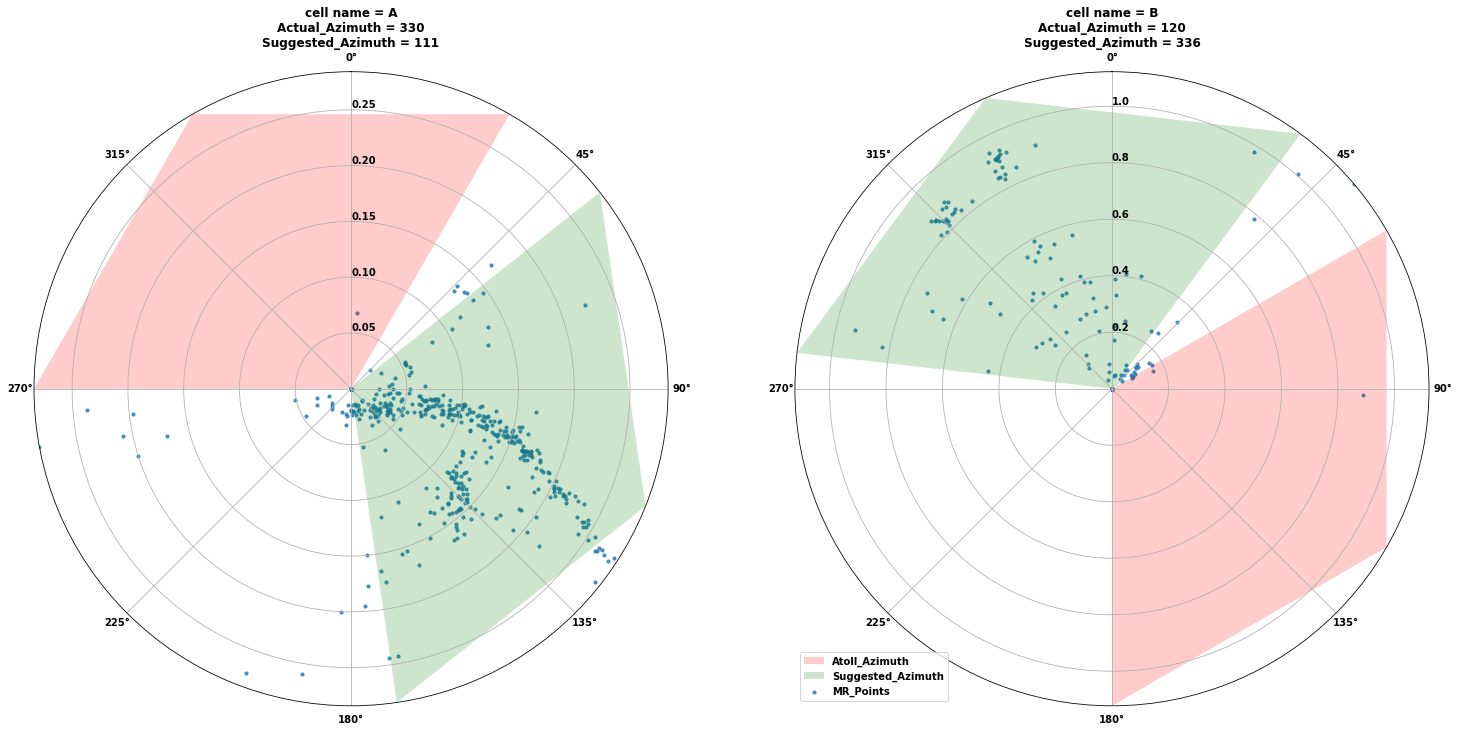

In [18]:
#call radar_graph function to each cell
radar_graph("A",1)
radar_graph("B",2)
#create a legend
plt.legend()
